In [1]:
%matplotlib inline
import numpy as np
from anisotropic_potential import LayeredHalfspace, apparent_conductivity
from anisotropic_potential_obj import AnisotropicPotentialObjectiveFunction
from objfunc import ModelObjectiveFunction, FCMObjectiveFunction
from utils import eff_anis_trans
import matplotlib.pyplot as plt
from time import time
import scipy.sparse as sp
from scipy.optimize import minimize

from IPython import display

In [2]:
#Setting up model
#sig1 = [10**-0.4, 10**-0.9, 10**-.3]
#sig2 = [10**-0.2, 10**-0.3, 10**-.3]
#sig3 = [10**-0.1, 10**-0.0, 10**-.3]
#alpha = [3*np.pi/20, -np.pi/8, 0]
#betas = [0, -3*np.pi/8, 0]
#gamma = [0, 3*np.pi/8, 0]
#zs = [0, 5, 25]

#Setting up model
sig1 = [10**-0.4, 10**0.0, 10**-.3]
sig2 = [10**-0.1, 10**-.3, 10**-.3]
sig3 = [10**-0.4, 10**-.9, 10**-.3]
alpha = [3*np.pi/20, -np.pi/5, 0]
betas = [0, -3*np.pi/5, 0]
gamma = [0, 3*np.pi/5, 0]
zs = [0, 5, 25]

forward_space = LayeredHalfspace(zs, sig1, sig2, sig3, alpha, betas, gamma)

#Setting up observation points
wenner_distances= np.array([-3,-1,1,3])
scales = np.logspace(0,4.5,15)

Axs = wenner_distances[0]*scales
Mxs = wenner_distances[1]*scales
Nxs = wenner_distances[2]*scales
Bxs = wenner_distances[3]*scales
Ays = np.zeros_like(Axs)
Bys = np.zeros_like(Bxs)
Mys = np.zeros_like(Mxs)
Nys = np.zeros_like(Nxs)

#Rotations to perform:
rs = np.array([0, np.pi/4, np.pi/2, 3*np.pi/4])
Xs_a, Ys_a = [],[]
Xs_b, Ys_b = [],[]
Xs_m, Ys_m = [],[]
Xs_n, Ys_n = [],[]
for r in rs:
    rot = np.array([[np.cos(r),-np.sin(r)],[np.sin(r),np.cos(r)]])
    
    x, y = rot@np.c_[Axs, Ays].T
    Xs_a.append(x), Ys_a.append(y)
    
    x, y = rot@np.c_[Bxs, Bys].T
    Xs_b.append(x), Ys_b.append(y)
    
    x, y = rot@np.c_[Mxs, Mys].T
    Xs_m.append(x), Ys_m.append(y)
    
    x, y = rot@np.c_[Nxs, Nys].T
    Xs_n.append(x), Ys_n.append(y)

Ax = np.hstack(Xs_a)
Ay = np.hstack(Ys_a)
Bx = np.hstack(Xs_b)
By = np.hstack(Ys_b)
Mx = np.hstack(Xs_m)
My = np.hstack(Ys_m)
Nx = np.hstack(Xs_n)
Ny = np.hstack(Ys_n)
    
A = np.c_[Ax, Ay].T
B = np.c_[Bx, By].T
M = np.c_[Mx, My].T
N = np.c_[Nx, Ny].T

In [3]:
volts = forward_space.voltage(A, B, M, N)

np.random.seed(1)
d_obs = volts+np.random.randn(*volts.shape)*volts*0.01
Wd = sp.diags(1/(0.01*volts))

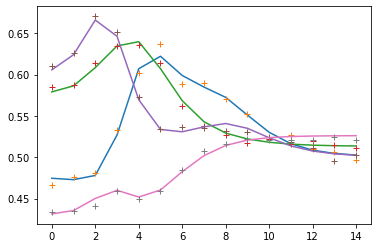

In [4]:
rhoa_true = apparent_conductivity(volts, A, B, M, N)
rhoa_obs = apparent_conductivity(d_obs, A, B, M, N)
for i in range(4):
    plt.plot(rhoa_true[15*i:(i+1)*15], label=i)
    plt.plot(rhoa_obs[15*i:(i+1)*15],'+')

In [5]:
n_inv_layers = 50
s1 = np.ones(n_inv_layers)*10**-.3
s2 = np.ones(n_inv_layers)*10**-.3
s3 = np.ones(n_inv_layers)*10**-.3
a = np.zeros(n_inv_layers)
b = np.zeros(n_inv_layers)
g = np.zeros(n_inv_layers)
zs = np.logspace(0,3,50)-1 #log spaced widths
dz = zs[1:]-zs[:-1]
dz = np.append(dz,dz[-1])

mref = np.concatenate((np.log(s1), np.log(s2), np.log(s3), a, b, g))
mi = mref.copy()
options = {'disp':True}

In [6]:
mod_folder = "Models/star_cross/"

In [7]:
PhiD = AnisotropicPotentialObjectiveFunction(zs, (A, B, M, N), d_obs, Wd=Wd)

In [8]:
weights = 1/(np.abs(zs)+1)**2
weights /= weights.max()
weights[-1] = 100
#weights2 = (weights[1:]+weights[:-1])/2

Wz = sp.diags(dz)*sp.diags([-1/dz,1/dz],[0,1],shape=(n_inv_layers,n_inv_layers))
Wz = sp.block_diag([Wz]*3+[Wz]*3).tocsr()
Ws = sp.block_diag([sp.diags(weights*np.sqrt(dz))]*3+[sp.diags(np.sqrt(dz))]*3)

W_anis = sp.diags([-1,-1,2,-1,-1],
                  [-2*n_inv_layers,-n_inv_layers,0,n_inv_layers,2*n_inv_layers],
                  shape=(3*n_inv_layers, 3*n_inv_layers))
W_anis = sp.block_diag((W_anis, sp.csr_matrix(W_anis.shape)))
PhiM = ModelObjectiveFunction(0.25*Ws.T@Ws+100*Wz.T@Wz+1*W_anis, mref=mref)
PhiM2 = ModelObjectiveFunction(100*Wz.T@Wz+1*W_anis, mref=mref)

In [9]:
def callback(x):
    print(Phi(x), PhiD(x), PhiM(x))

In [10]:
beta = 50
Phi = PhiD+beta*PhiM

x = mi
print(Phi(x), PhiD(x), PhiM(x))
out = minimize(0.5*Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback, tol=1E-3)
x = out['x']
print('PhiD:', PhiD(x))
np.save(mod_folder + 'beta50',x)

9724.383909732365 9724.383909732365 0.0
5512.8018243731785 5393.680168512173 2.3824331172201183
3948.694776250498 3721.6718519455976 4.540458486098003
2487.556253026417 1830.2573364927707 13.145978330672921
2125.7366957468516 1267.4479512339553 17.16577489025793
2053.4907140360947 1130.2655246849126 18.464503787023638
2008.1108287757934 997.4603262831394 20.213010049853082
1993.9015867941655 965.2980842557834 20.572070050767643
1986.6725325327047 962.485657379335 20.483737503067395
1981.063133642751 975.4531745455025 20.112199181944966
1976.4822592751393 983.0963584537569 19.867718016427645
1972.174009474368 994.6635595981694 19.55020899752397
1968.405379827175 1002.1129578242347 19.325848440058806
1964.4753710945852 1012.4628331571569 19.040250758748567
1949.3279759362867 1027.5268642813098 18.436022233099536
1943.9150343339857 1050.551358982149 17.86727350703673
1937.752367330918 1062.5627703631787 17.503791939354787
1931.765374545601 1057.2263307047651 17.490780876816714
1926.674772

In [11]:
beta = 10
Phi = PhiD+beta*PhiM

x = np.load(mod_folder + 'beta50.npy')
print(Phi(x), PhiD(x), PhiM(x))
out = minimize(0.5*Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback, tol=1E-3)
x = out['x']
print('PhiD:', PhiD(x))
np.save(mod_folder + 'beta10',x)

940.1711974141922 734.4319793935113 20.573921802068092
674.5777605370508 316.8841434749628 35.7693617062088
617.4042004474437 214.40757712141522 40.29966233260285
582.9722098548924 144.9924985090415 43.79797113458509
576.3707010994492 141.49100097652624 43.487970012292294
569.4908715791553 131.72591379334492 43.77649577858104
568.9043522608125 132.0111103063669 43.68932419544456
568.2721120187812 129.1038861843354 43.91682258344458
568.2018204694523 129.43874470029542 43.87630757691569
Optimization terminated successfully.
         Current function value: 284.100910
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
         Hessian evaluations: 79
PhiD: 129.43874470029542


In [12]:
beta = 2
Phi = PhiD+beta*PhiM

x = np.load(mod_folder + 'beta10.npy')
print(Phi(x), PhiD(x), PhiM(x))
out = minimize(0.5*Phi, x, method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p),
               options=options, callback=callback)
x = out['x']
print('PhiD:', PhiD(x))
np.save(mod_folder + 'beta2',x)

217.1913598541268 129.43874470029542 43.87630757691569
176.73405974546358 65.59761693585492 55.56822140480434
170.93377105010006 56.9108719460275 57.01144955203628
170.11609468018924 54.952200173914164 57.58194725313754
169.52743481191453 51.749187976076456 58.88912341791904
169.2991514935244 51.408870598897636 58.945140447313385
169.25032411985137 51.59248665295887 58.828918733446244
169.23258965981773 51.65241787523057 58.790085892293575
169.23087542617515 51.61598010145077 58.80744766236218
169.22863756609848 51.61795508335827 58.8053412413701
169.22803416349225 51.62922062801812 58.79940676773707
169.2279190764056 51.626093412326206 58.8009128320397
169.22786006234796 51.625353335395914 58.80125336347602
169.22785137309995 51.62455819723077 58.801646587934584
169.227845345833 51.624226702324115 58.80180932175444
169.22784455382566 51.62451529008932 58.80166463186818
Optimization terminated successfully.
         Current function value: 84.613922
         Iterations: 15
         Fun

In [13]:
#len(PhiD.d_pre)
x = np.load(mod_folder + 'beta2.npy')
print(PhiD(x))

51.62451529008932


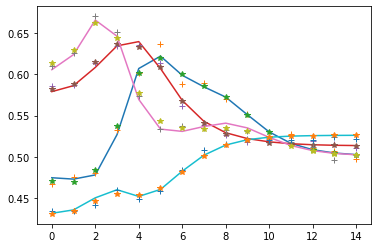

In [14]:
rhoa_pre = apparent_conductivity(PhiD.d_pre, A, B, M, N)
for i in range(4):
    plt.plot(rhoa_true[15*i:(i+1)*15], label=i)
    plt.plot(rhoa_obs[15*i:(i+1)*15],'+')
    plt.plot(rhoa_pre[15*i:(i+1)*15],'*')

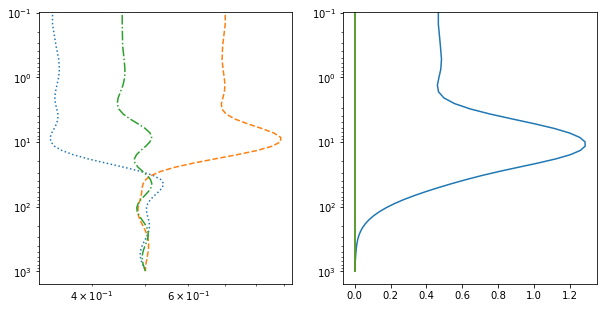

In [15]:
inv1 = np.exp(x.reshape(6,n_inv_layers)[0])
inv2 = np.exp(x.reshape(6,n_inv_layers)[1])
inv3 = np.exp(x.reshape(6,n_inv_layers)[2])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(inv1, zs,':')
plt.loglog(inv2, zs,"--")
plt.loglog(inv3, zs,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(x.reshape(6, n_inv_layers)[3], zs)
plt.semilogy(x.reshape(6, n_inv_layers)[4], zs)
plt.semilogy(x.reshape(6, n_inv_layers)[5], zs)
plt.gca().invert_yaxis()

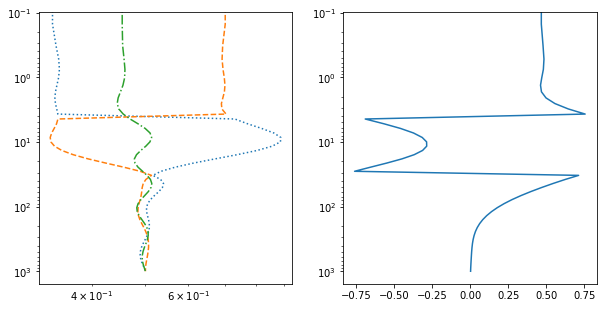

In [16]:
# Plot Effective Anisotropy:
mod = x.reshape(6, n_inv_layers).copy()
mod[:3] = np.exp(mod[:3])
m_eff = eff_anis_trans(*mod)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(m_eff[0], zs,':')
plt.loglog(m_eff[1], zs,"--")
plt.loglog(m_eff[2], zs,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(m_eff[3], zs)
plt.gca().invert_yaxis()

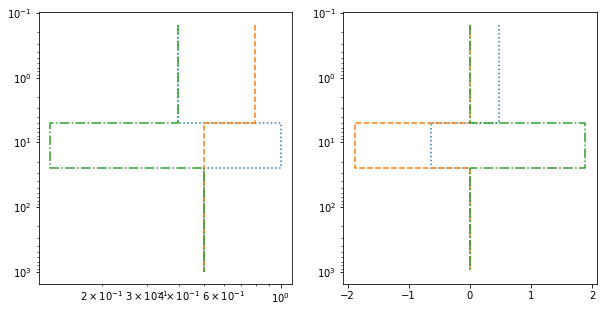

In [17]:
z = forward_space._z
zplot = np.array([zs[1],z[1],z[1],z[2],z[2],zs[-1]])
s1plot = np.array([sig1[0],sig1[0],sig1[1],sig1[1],sig1[2],sig1[2]])
s2plot = np.array([sig2[0],sig2[0],sig2[1],sig2[1],sig2[2],sig2[2]])
s3plot = np.array([sig3[0],sig3[0],sig3[1],sig3[1],sig3[2],sig3[2]])

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(s1plot, zplot, ':')
plt.loglog(s2plot, zplot, "--")
plt.loglog(s3plot, zplot, "-.")
plt.gca().invert_yaxis()

aplot = np.array([alpha[0],alpha[0],alpha[1],alpha[1],alpha[2],alpha[2]])
bplot = np.array([betas[0],betas[0],betas[1],betas[1],betas[2],betas[2]])
gplot = np.array([gamma[0],gamma[0],gamma[1],gamma[1],gamma[2],gamma[2]])
plt.subplot(1,2,2)
plt.semilogy(aplot,zplot,':')
plt.semilogy(bplot,zplot,"--")
plt.semilogy(gplot,zplot,"-.")
plt.gca().invert_yaxis()

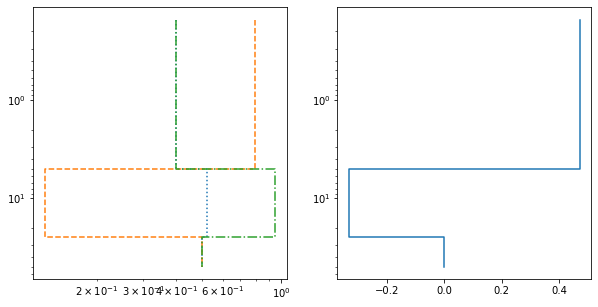

In [18]:
# Plot Effective Anisotropy:

zplot = np.array([zs[1],z[1],z[1],z[2],z[2],50])
s1plot = np.array([sig1[0],sig1[0],sig1[1],sig1[1],sig1[2],sig1[2]])
s2plot = np.array([sig2[0],sig2[0],sig2[1],sig2[1],sig2[2],sig2[2]])
s3plot = np.array([sig3[0],sig3[0],sig3[1],sig3[1],sig3[2],sig3[2]])
aplot = np.array([alpha[0],alpha[0],alpha[1],alpha[1],alpha[2],alpha[2]])
bplot = np.array([betas[0],betas[0],betas[1],betas[1],betas[2],betas[2]])
gplot = np.array([gamma[0],gamma[0],gamma[1],gamma[1],gamma[2],gamma[2]])

m_eff = eff_anis_trans(s1plot, s2plot, s3plot, aplot, bplot, gplot)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(m_eff[0], zplot,':')
plt.loglog(m_eff[1], zplot,"--")
plt.loglog(m_eff[2], zplot,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(m_eff[3], zplot)
plt.gca().invert_yaxis()

In [19]:
def plot_model(xi, u, i):

    plt.figure(figsize=(15,5))
    
    plt.subplot(1,3,1)
    inv1 = np.exp(xi.reshape(6,n_inv_layers)[0])
    inv2 = np.exp(xi.reshape(6,n_inv_layers)[1])
    inv3 = np.exp(xi.reshape(6,n_inv_layers)[2])
    plt.loglog(inv1, zs,':')
    plt.loglog(inv2, zs,"--")
    plt.loglog(inv3, zs,"-.")
    plt.gca().invert_yaxis()

    plt.subplot(1,3,2)
    plt.semilogy(xi.reshape(6, n_inv_layers)[3], zs,":")
    plt.semilogy(xi.reshape(6, n_inv_layers)[4], zs,"--")
    plt.semilogy(xi.reshape(6, n_inv_layers)[5], zs,"-.")
    plt.gca().invert_yaxis()
    plt.title('Iteration {}'.format(i+1))

    plt.subplot(1,3,3)
    inv1 = u[0]
    inv2 = u[1]
    inv3 = u[2]
    plt.semilogy(inv1, zs,':')
    plt.semilogy(inv2, zs,"--")
    plt.semilogy(inv3, zs,"-.")
    plt.gca().invert_yaxis()

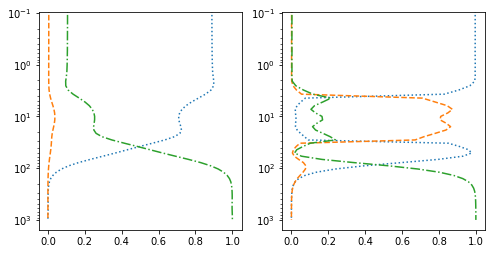

In [20]:
xi = np.load(mod_folder + 'beta2.npy')
log10 = np.log(10)
tk = np.array([[-0.4*log10, -0.1*log10, -0.4*log10, 3*np.pi/20, 0, 0],
               [0.0*log10, -0.3*log10, -0.9*log10, -np.pi/5, -3*np.pi/5, 3*np.pi/5],
               [-0.3*log10, -0.3*log10, -0.3*log10, 0, 0, 0]])
v = tk
PhiFCM = FCMObjectiveFunction(tk, 0)
for i in range(10):
    u = PhiFCM.updateU(xi, v)
    v = PhiFCM.updateV(xi, u, 0)
v_eff = v.copy()
v_eff[:,:3] = np.exp(v_eff[:,:3])
v_eff = np.c_[eff_anis_trans(*v_eff.T)]
v_eff[:, :3] = np.log(v_eff[:,:3])

tk_eff = tk.copy()
tk_eff[:,:3] = np.exp(tk_eff[:,:3])
tk_eff = np.c_[eff_anis_trans(*tk_eff.T)]
tk_eff[:, :3] = np.log(tk_eff[:,:3])

mod = xi.reshape(6, n_inv_layers).copy()
mod[:3] = np.exp(mod[:3])
m_eff = np.r_[eff_anis_trans(*mod)].reshape(4, -1)
m_eff[:3] = np.log(m_eff[:3])
m_eff = m_eff.reshape(-1)

eta = 2

PhiFCM = FCMObjectiveFunction(tk, eta, vi=v, w=[1,1,1,1,1,1])
PhiFCM_eff = FCMObjectiveFunction(tk_eff, eta,  w=np.array([0.01,0.01,0.01,1]))

u = PhiFCM.updateU(xi, tk)
u_eff = PhiFCM_eff.updateU(m_eff, tk_eff)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.semilogy(u[0], zs,':')
plt.semilogy(u[1], zs,"--")
plt.semilogy(u[2], zs,"-.")
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.semilogy(u_eff[0], zs,':')
plt.semilogy(u_eff[1], zs,"--")
plt.semilogy(u_eff[2], zs,"-.")
plt.gca().invert_yaxis()

In [21]:
for i in range(3):
    print(np.linalg.norm(v[i]-tk,axis=1),np.linalg.norm(v_eff[i]-tk_eff,axis=1))

[0.24441439 3.35787295 0.7058749 ] [0.24441439 2.05951811 0.7058749 ]
[0.72286691 3.6608663  1.27899366] [1.38842506 1.28992265 0.69608211]
[0.67598753 3.1624978  0.1054369 ] [0.67598753 1.57521    0.1054369 ]


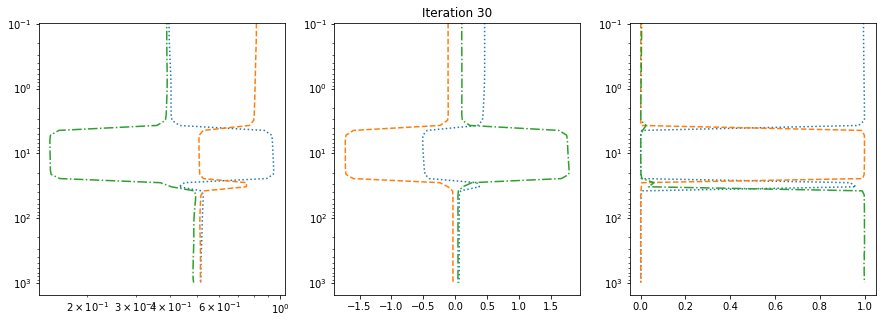

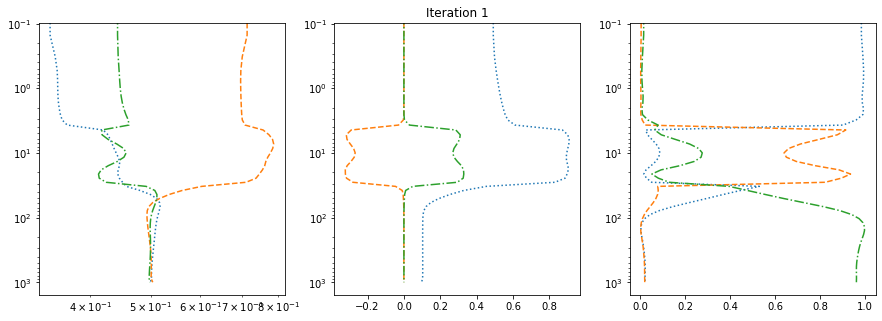

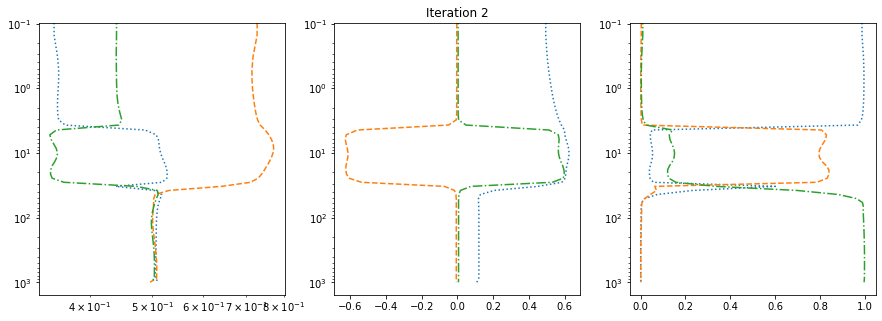

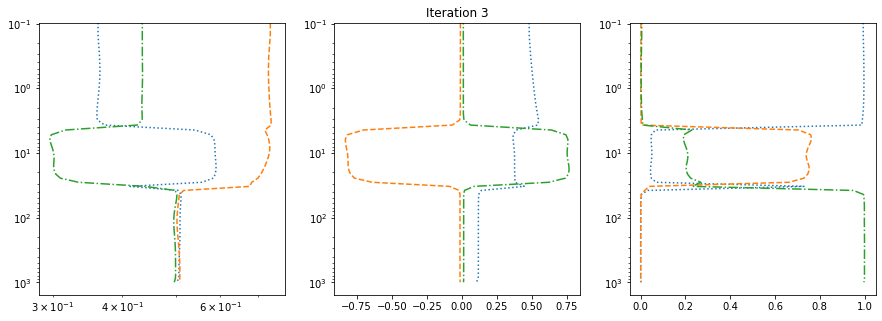

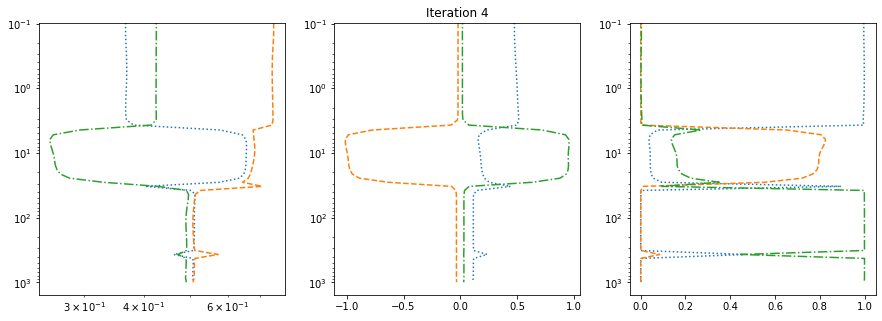

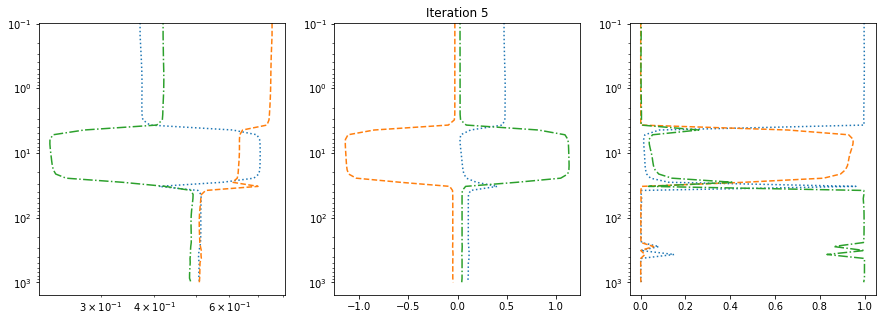

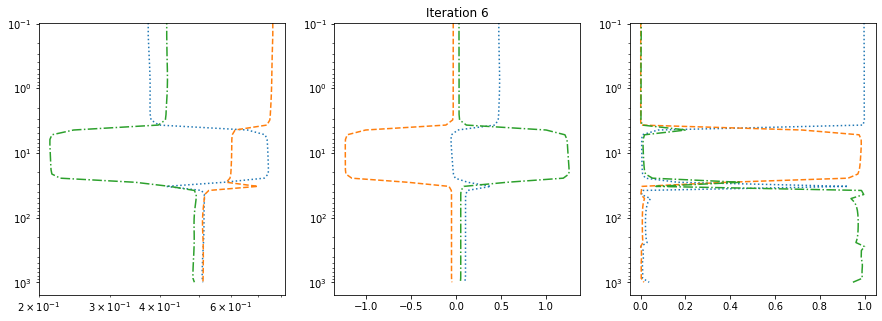

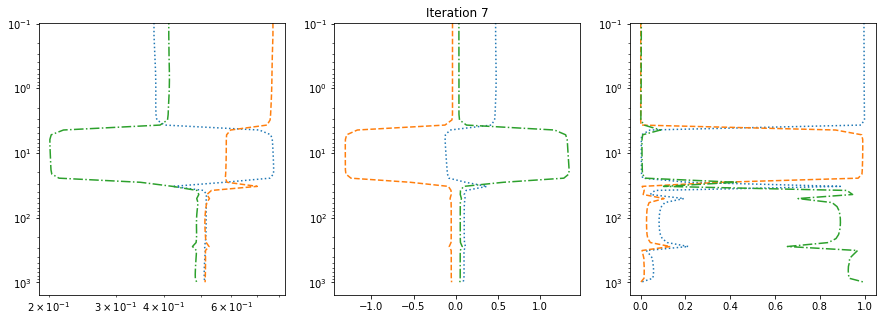

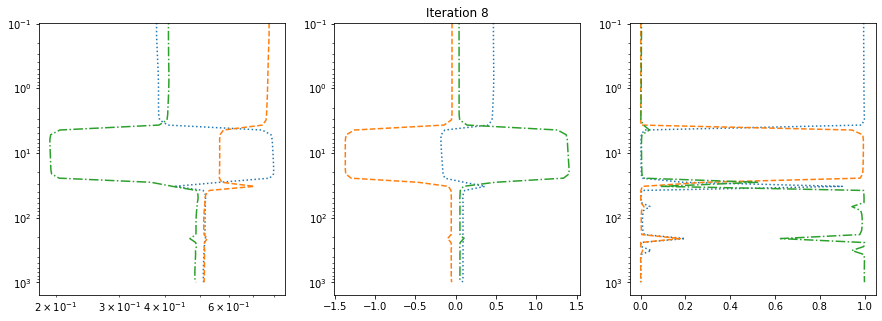

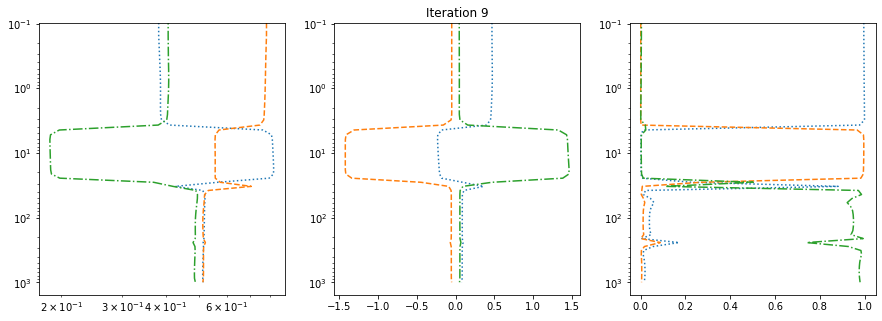

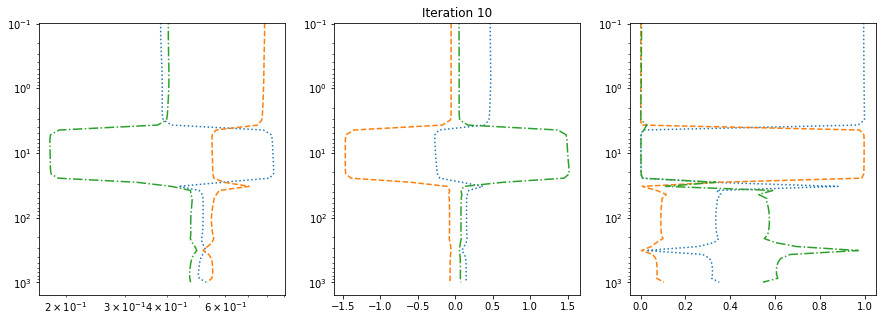

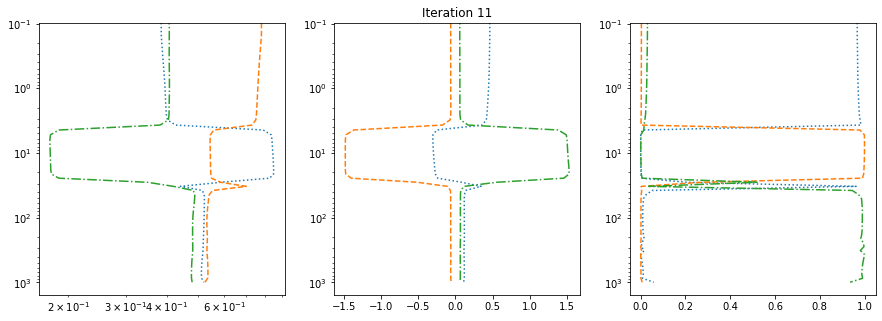

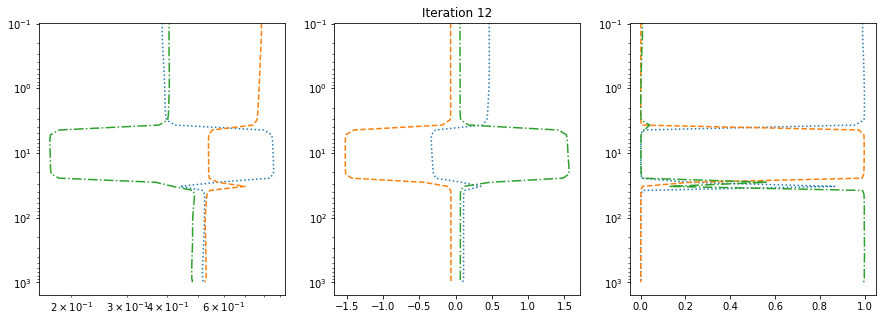

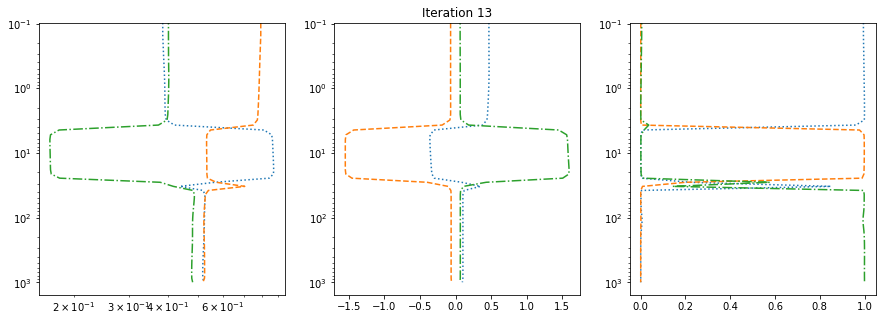

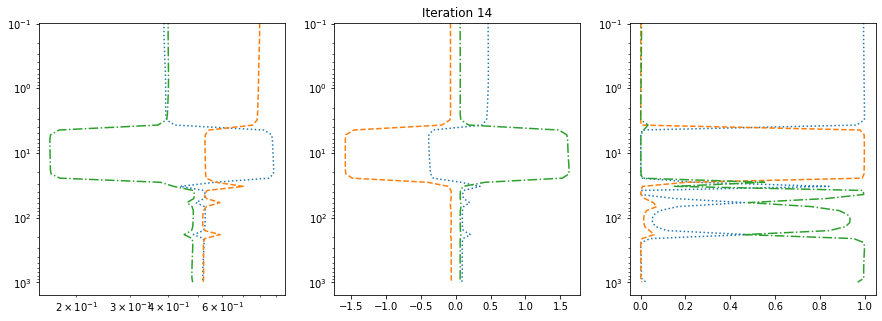

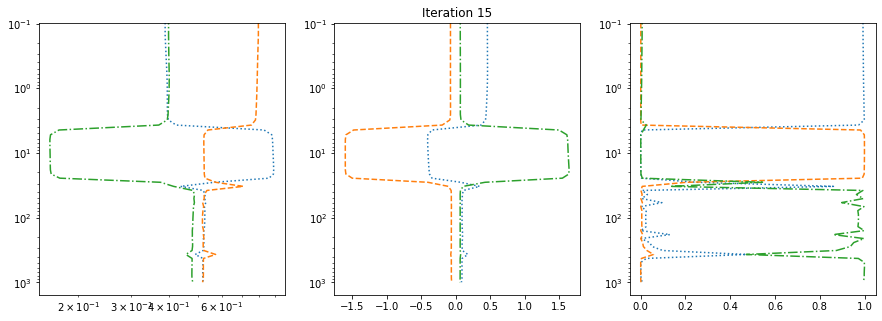

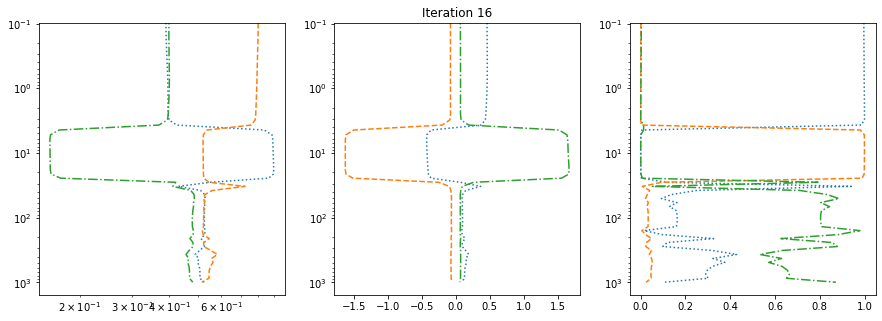

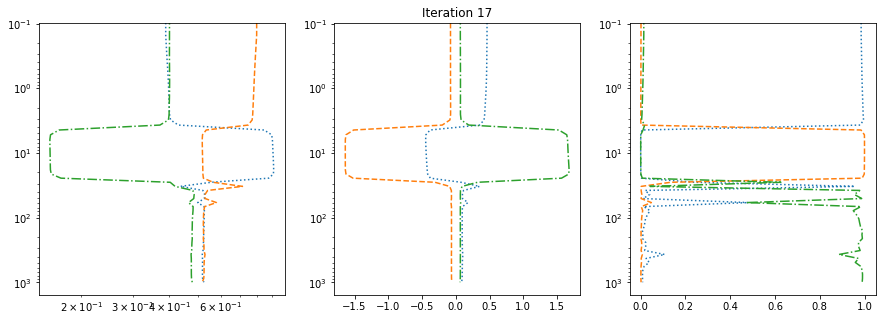

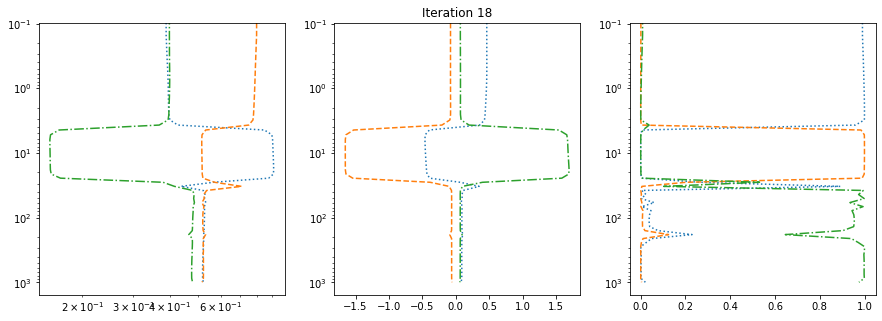

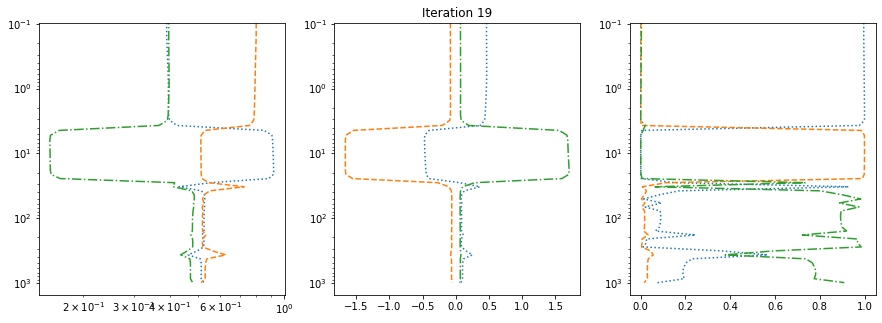

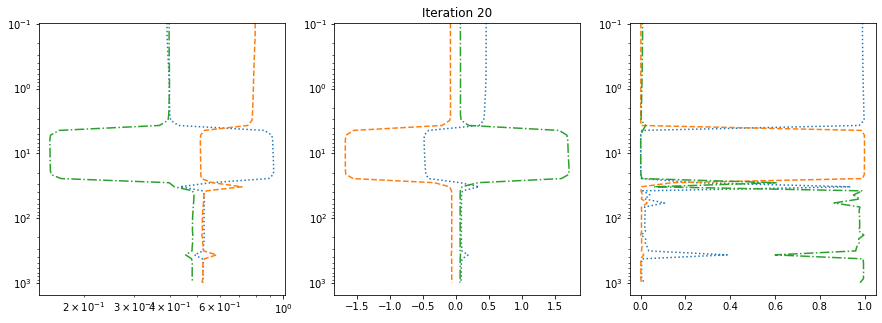

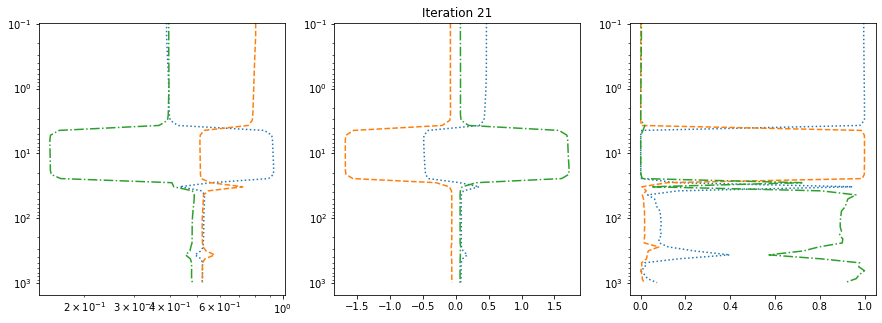

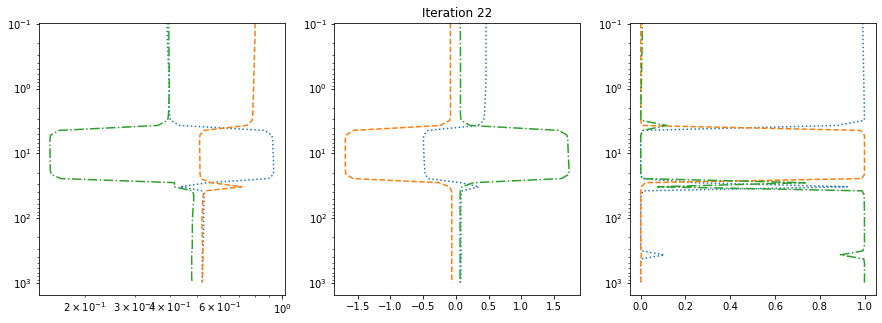

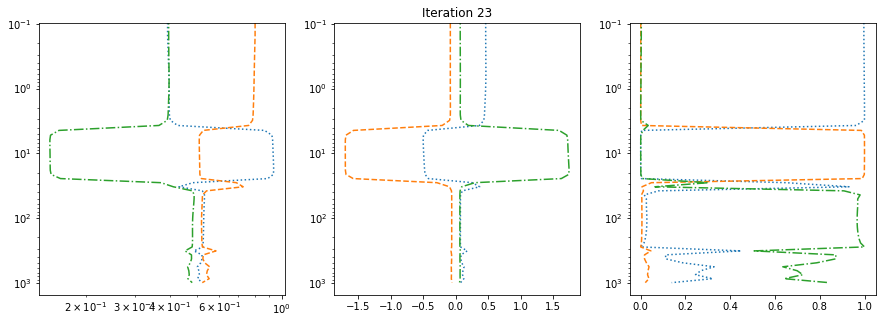

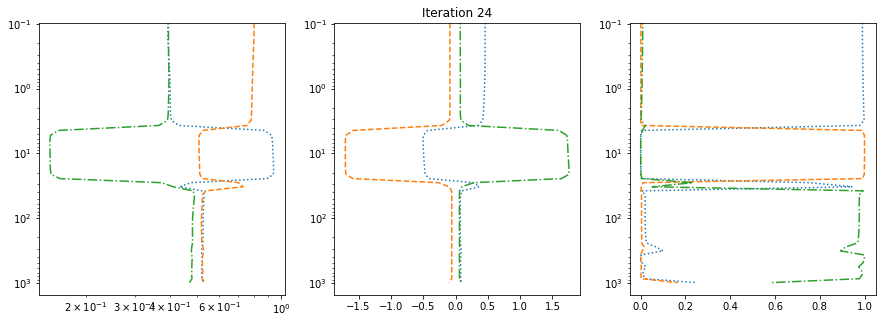

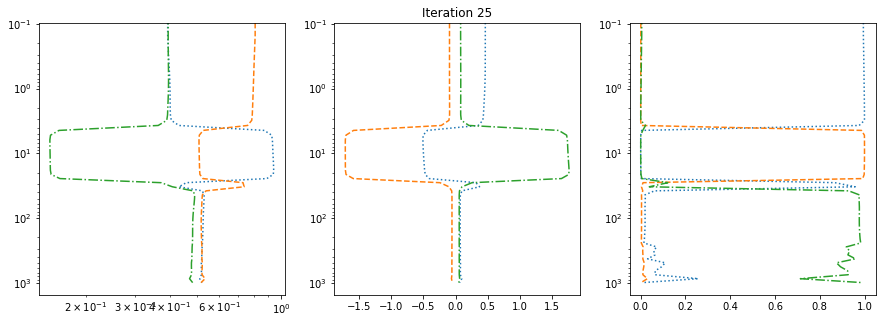

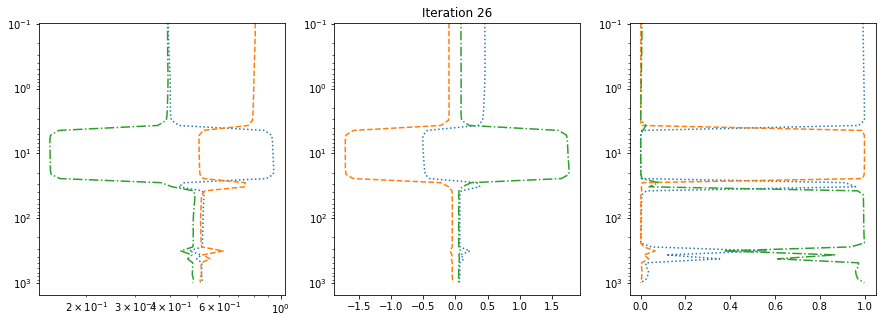

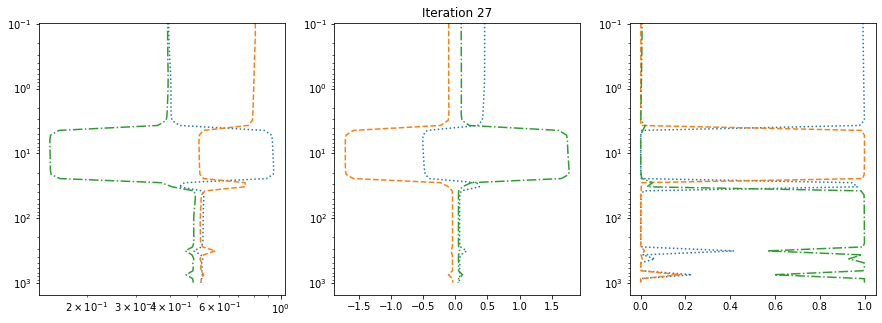

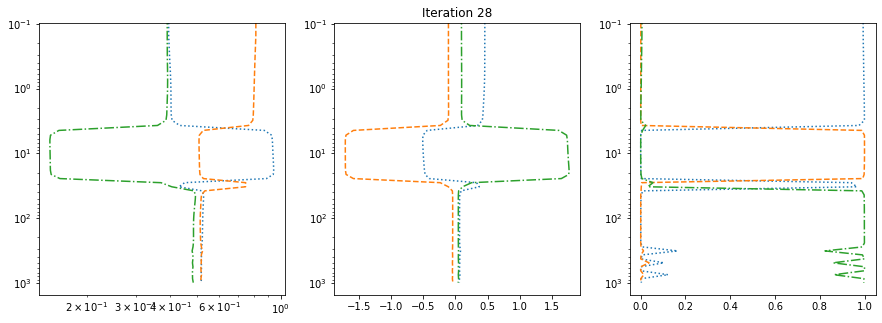

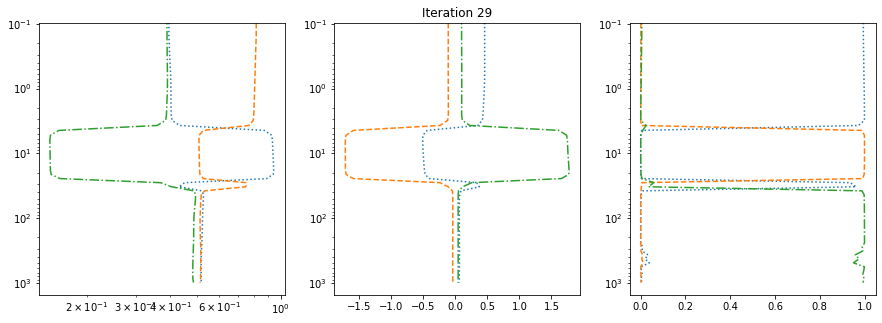

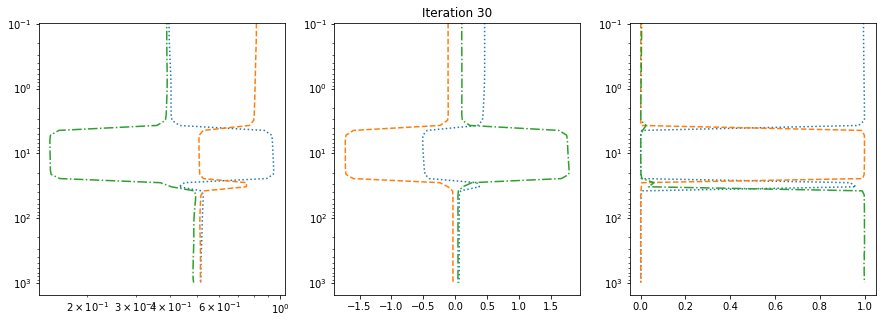

In [22]:
beta = 1.0
lamb = 1000
eta = 2

PhiFCM_eff = FCMObjectiveFunction(tk_eff, eta)
u=PhiFCM_eff.updateU(m_eff, v_eff)

PhiFCM = FCMObjectiveFunction(tk, eta, vi=v)
PhiFCM.u = PhiFCM_eff.u

Phi = PhiD+beta*PhiM2+lamb*PhiFCM

vi = v.copy()
xi = np.load(mod_folder + 'beta2.npy').reshape(-1)
PhiFCM.update_internals()
print(xi.shape)

callback(xi)
phimkm1 = PhiM(xi)
for i in range(30):
    #print('Iteration', i+1)
        
    ###
    # Update v based on xi and effective and u
    v = PhiFCM.updateV(xi, u, eta)
    
    v_eff = v.copy()
    v_eff[:,:3] = np.exp(v_eff[:,:3])
    v_eff = np.c_[eff_anis_trans(*v_eff.T)]
    v_eff[:, :3] = np.log(v_eff[:,:3])
    
    m_eff = xi.reshape(6, n_inv_layers).copy()
    m_eff[:3] = np.exp(m_eff[:3])
    m_eff = np.r_[eff_anis_trans(*m_eff)].reshape(4, n_inv_layers)
    m_eff[:3] = np.log(m_eff[:3])
    m_eff = m_eff.reshape(-1)
    
    norm1 = np.linalg.norm(v-tk)
    norm2 = np.linalg.norm(v_eff-tk_eff)
    print(norm1, norm2)
    if norm2<norm1:
        # Update membership using v_eff
        u = PhiFCM_eff.updateU(m_eff, v_eff)
    else:
        u = PhiFCM.updateU(xi.reshape(6, -1), v)
    PhiFCM.u = u
    
    PhiFCM.update_internals()
    ###
    print(v, PhiFCM(xi.reshape(-1)))
    
    Phi = PhiD+beta*PhiM2+lamb*PhiFCM
    
    out = minimize(Phi, xi.reshape(-1), method='Newton-CG', jac=Phi.d, hessp=lambda xk, p: Phi.H(p), tol=1E-2,
                  callback=callback)
    xi = out['x']
    plot_model(xi, PhiFCM.u, i)
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    phimk = PhiM(xi)
    rel_phim = np.abs(phimk-phimkm1)/phimkm1
    #print(rel_phim)
    if(rel_phim<1E-4):
        break
    phimkm1 = phimk
    

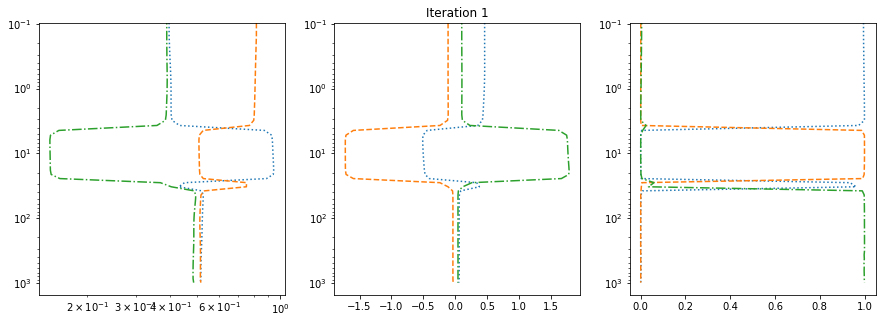

In [23]:
plot_model(xi, PhiFCM.u, 0)

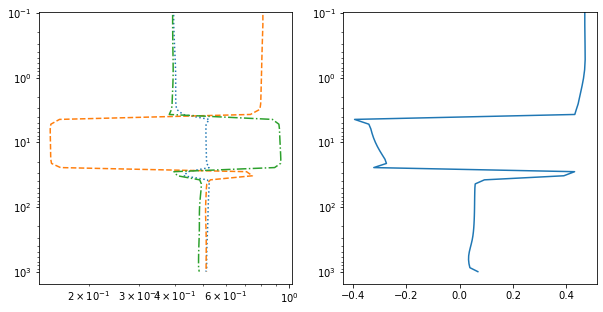

In [24]:
# Plot Effective Anisotropy:
mod = xi.reshape(6, n_inv_layers).copy()
mod[:3] = np.exp(mod[:3])
m_eff = eff_anis_trans(*mod)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.loglog(m_eff[0], zs,':')
plt.loglog(m_eff[1], zs,"--")
plt.loglog(m_eff[2], zs,"-.")
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.semilogy(m_eff[3], zs)
plt.gca().invert_yaxis()

In [25]:
np.save(mod_folder + 'm_fcm_eff',xi)
PhiD(xi)

78.73049129544751

In [26]:
np.linalg.norm(v-tk), np.linalg.norm(v_eff-tk_eff)

(0.341784835050437, 0.16285531208667073)

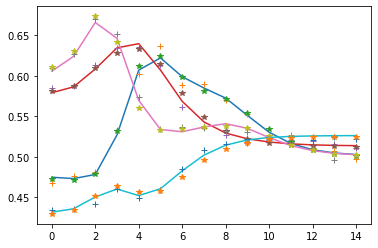

In [27]:
rhoa_pre = apparent_conductivity(PhiD.d_pre, A, B, M, N)
for i in range(4):
    plt.plot(rhoa_true[15*i:(i+1)*15], label=i)
    plt.plot(rhoa_obs[15*i:(i+1)*15],'+')
    plt.plot(rhoa_pre[15*i:(i+1)*15],'*')

In [28]:
x = np.load(mod_folder + 'beta2.npy'); PhiD(xi);
rhoa_pre1 = apparent_conductivity(PhiD.d_pre, A, B, M, N)

x = np.load(mod_folder + 'm_fcm_eff.npy'); PhiD(xi);
rhoa_pre2 = apparent_conductivity(PhiD.d_pre, A, B, M, N)

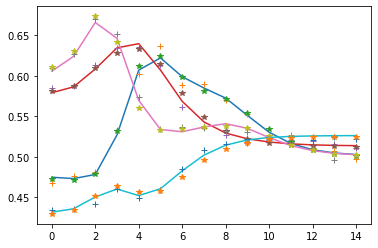

In [29]:
rhoa_pre = apparent_conductivity(PhiD.d_pre, A, B, M, N)
for i in range(4):
    plt.plot(rhoa_true[15*i:(i+1)*15], label=i)
    plt.plot(rhoa_obs[15*i:(i+1)*15],'+')
    plt.plot(rhoa_pre2[15*i:(i+1)*15],'*')

In [30]:
np.savez(mod_folder + 'data',
         rhoa_true=rhoa_true,
         rhoa_obs=rhoa_obs,
         rhoa_smooth=rhoa_pre1,
         rhoa_fcm=rhoa_pre2)